In [7]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime, timezone
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, MaxPooling1D, Conv1D, LSTM, SimpleRNN
from kerastuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import f1_score

In [8]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [9]:
def normalizeTime(df):
    for i, row in df.iterrows():
        df.at[i, 'Time'] = math.sin(2 * math.pi * (int(str(df.at[i, 'Time']).split(':')[0])*60 + int(str(df.at[i, 'Time']).split(':')[1])) / 1440)
    return df
data1 = pd.read_csv("EnergyPlus Models/1D.csv")
data1 = normalizeTime(data1)
data3000 = pd.read_csv("EnergyPlus Models/3000D.csv")
data3000 = normalizeTime(data3000)
data6000 = pd.read_csv("EnergyPlus Models/6000D.csv")
data6000 = normalizeTime(data6000)
data1['Heating Load [W]'] = data1["SPACE1-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data1["SPACE2-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data1["SPACE3-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data1["SPACE4-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data1["SPACE5-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] 
data3000['Heating Load [W]'] = data3000["SPACE1-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data3000["SPACE2-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data3000["SPACE3-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data3000["SPACE4-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data3000["SPACE5-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] 
data6000['Heating Load [W]'] = data6000["SPACE1-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data6000["SPACE2-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data6000["SPACE3-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data6000["SPACE4-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] + data6000["SPACE5-1:CHICAGO_IL_USA ANNUAL HEATING 99% DESIGN CONDITIONS DB:Des Heat Load [W]"] 
data1['Cooling Load [W]'] = data1["SPACE1-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data1["SPACE2-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data1["SPACE3-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data1["SPACE4-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data1["SPACE5-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"]
data3000['Cooling Load [W]'] = data3000["SPACE1-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data3000["SPACE2-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data3000["SPACE3-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data3000["SPACE4-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data3000["SPACE5-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"]
data6000['Cooling Load [W]'] = data6000["SPACE1-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data6000["SPACE2-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data6000["SPACE3-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data6000["SPACE4-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"] + data6000["SPACE5-1:CHICAGO_IL_USA ANNUAL COOLING 1% DESIGN CONDITIONS DB/MCWB:Des Sens Cool Load [W]"]
data1['Total Load [W]'] = data1['Heating Load [W]'] + data1['Cooling Load [W]']
data3000['Total Load [W]'] = data3000['Heating Load [W]'] + data3000['Cooling Load [W]']
data6000['Total Load [W]'] = data6000['Heating Load [W]'] + data6000['Cooling Load [W]']

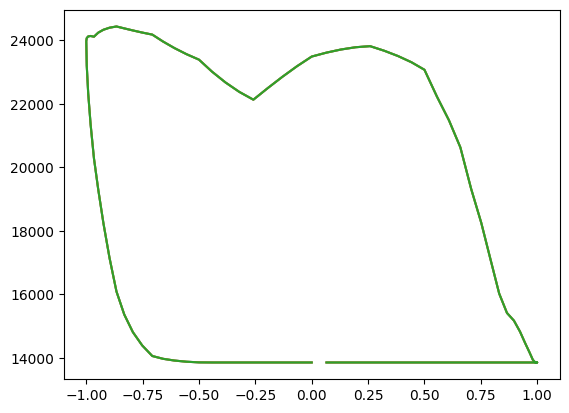

In [10]:
plt.plot(data1['Time'], data1['Total Load [W]'])
plt.plot(data3000['Time'], data3000['Total Load [W]'])
plt.plot(data6000['Time'], data6000['Total Load [W]'])
plt.show()

In [11]:
x1 = []
d1 = np.array(data1['Total Load [W]'])
for i in range(len(d1)):
    if i >= 3:
        x1.append(d1[i-3:i].tolist())
x3000 = []
d3000 = np.array(data3000['Total Load [W]'])
for i in range(len(d3000)):
    if i >= 3:
        x3000.append(d3000[i-3:i].tolist())
x6000 = []
d6000 = np.array(data6000['Total Load [W]'])
for i in range(len(d6000)):
    if i >= 3:
        x6000.append(d6000[i-3:i].tolist())
xTrain = x1 + x3000 + x6000
xTrain = np.array(xTrain).astype(float)
yTrain = np.array(data1['Total Load [W]'][3:]).tolist() + np.array(data3000['Total Load [W]'][3:]).tolist() + np.array(data6000['Total Load [W]'][3:]).tolist()
yTrain = np.array(yTrain).astype(float)
print(xTrain)
print(yTrain)
early_stopping_callback = EarlyStopping(monitor='loss', patience=3)
model = Sequential()
model.add(Input((3,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(optimizer="adam", loss="mse")
model.fit(xTrain, yTrain, epochs=1000, callbacks=[early_stopping_callback])

[[13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.362   ]
 [13854.362    13854.362    13854.

In [12]:
predictions = model.predict(np.array(data1['Time']).astype(float))
plt.plot(data1['Time'], predictions)
plt.plot(data1['Time'], data1['Total Load [W]'])
plt.show()

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32,), dtype=float32). Expected shape (None, 3), but input has incompatible shape (32,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32,), dtype=float32)
  • training=False
  • mask=None